In [1]:
import altair as alt
from vega_datasets import data
import pandas as pd
import numpy as np
#alt.data_transformers.disable_max_rows()
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
data = pd.read_csv('forestfires.csv')

In [3]:
data_melt=pd.melt(data,['X','Y','month', 'day', 'area',
                        'wind', 'RH','temp','rain'])
# This is the list with the sorted months to be used afterwards
sorted_months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

In [4]:
# This will be the selector for the heatmap
box_selector=alt.selection_multi(fields=['X','Y'], nearest=False, on='click',)

# This is the selector for top right bar chart
bar_selector =alt.selection_multi(fields=['variable'], nearest=False, on='click',)

# This is the list with months for the dropdown menu
dropdown_list = sorted_months

In [5]:
# MONTH CHANGER =================================
# This is the box that change the month
dropdown_box = alt.binding_select(options=dropdown_list)
# This is the event holder for the box
dropdown_selection = alt.selection_single(name='Picked',fields=['month'], bind=dropdown_box)

In [6]:
# The color will change when a box is clicked on the heatmap
# This will be the condition handler
color_changer =alt.condition(box_selector, 'count():Q', alt.value('lightgray'), title = 'Fire incidents',
                       scale=alt.Scale(scheme="yelloworangered"),
                           legend=alt.Legend(orient = "left", offset = 0))

In [7]:
# heat map for the fires==============================================
#=====================================================================
overall_fires=alt.Chart(data).mark_rect().encode(
    alt.X('X:N', title = 'X coordinate', sort= 'descending'),
    alt.Y('Y:O',sort = alt.Sort('descending'), title = 'Y coordinate'),
    color= color_changer,
    tooltip = ['mean(DMC):Q','mean(DC):Q','mean(FFMC):Q', 
               'mean(ISI):Q','count():Q', 'sum(area):Q'],
).properties(
    width=340,
    height=340,
    title='Summary of Fires'
).add_selection(box_selector).transform_filter(dropdown_selection)

# The inner part of showing the burned area=====================
#=======================================================================
area_burned = alt.Chart(data).mark_point(shape = "diamond", fill='black', color='red').encode(
    alt.X('X:N', title = 'X coordinate'),
    alt.Y('Y:N',sort = 'descending', title = 'Y coordinate'),
    size = alt.Size('sum(area):Q', scale = alt.Scale(domain = [100,200,300],type = 'threshold'),
                   title = 'Area burned (ha)',
                   legend=alt.Legend(orient='left',offset = 0)),
    tooltip = ['sum(area):Q']
).transform_filter(dropdown_selection).properties(
    width=340,
    height=340)
#

In [8]:
# Meteorological Graphs ==============================================
#=====================================================================

#wind
wind = alt.Chart(data).mark_boxplot(clip=True, extent='min-max').encode(
    alt.X('month:N',sort=alt.Sort(sorted_months)),
    y=alt.Y('wind:Q', title='Wind (km/h)'),
    color=alt.Color('count():Q',legend=alt.Legend(orient='left'),
                   scale=alt.Scale(scheme = 'bluepurple'),title='Incidents of Fire')
).properties(
    title = 'Wind',
    width=200,
    height=200,
).transform_filter(
    box_selector
)

# RH===================================================================
RH = alt.Chart(data).mark_boxplot(clip=True, extent = 'min-max').encode(
    alt.X('month:N',sort=alt.Sort(sorted_months)),
    y=alt.Y('RH:Q', title = 'Relative Humidity (%)'),
    color=alt.Color('count():Q',legend=None,scale=alt.Scale(scheme = 'bluepurple'))
).properties(
    title = 'Relative Humidity',
    width=200,
    height=200,
).transform_filter(
    box_selector
)


#temp==================================================================
temp=alt.Chart(data).mark_boxplot(clip=True, extent='min-max').encode(
    alt.X('month:N',sort=alt.Sort(sorted_months),
         scale=alt.Scale(zero=False)),
    alt.Y('temp:Q', title = 'Temperature (C)'),
    color=alt.Color('count():Q',legend=None,scale=alt.Scale(scheme = 'bluepurple'))
).properties(
    title = 'Temperature',
    width=200,
    height=200,
).transform_filter(
    box_selector
)

In [9]:
# Factor chart to present the different factors of the fire
month_selector =alt.selection_single(fields=['month'], nearest=False, on='click',)

bar_chart_factor = alt.Chart(data_melt).mark_bar().encode(
    x=alt.X('variable:N', scale = alt.Scale(rangeStep = 100)),
    y=alt.Y('mean(value):Q',bin = False, title = "Value "),
    color = alt.condition(bar_selector,
                          alt.Color('variable:N',scale =alt.Scale(scheme = 'category20b'),legend = None),
                          alt.value('lightgray')),
    tooltip = ['variable:N','mean(value):Q']
).properties(
    width=300,
    height=300,
    title='Fire Factor Data'
).add_selection(
    dropdown_selection,
    bar_selector
).transform_filter(
    dropdown_selection
).transform_filter(box_selector)

monthly_dist = alt.Chart(data_melt).mark_bar(color='purple').encode(
    alt.X('month:N', sort =alt.Sort(sorted_months)),
    alt.Y('mean(value):Q')
).properties(
    width = 500,
    height = 150,
    title = 'Monthly distribution over the chosen metric'
).add_selection(month_selector).transform_filter(bar_selector)



In [10]:
# Final Visualization Design
fires_factors = overall_fires + area_burned | bar_chart_factor


In [11]:
box_charts = wind | RH | temp


In [12]:
final_chart = (fires_factors & box_charts).resolve_scale(color='independent')

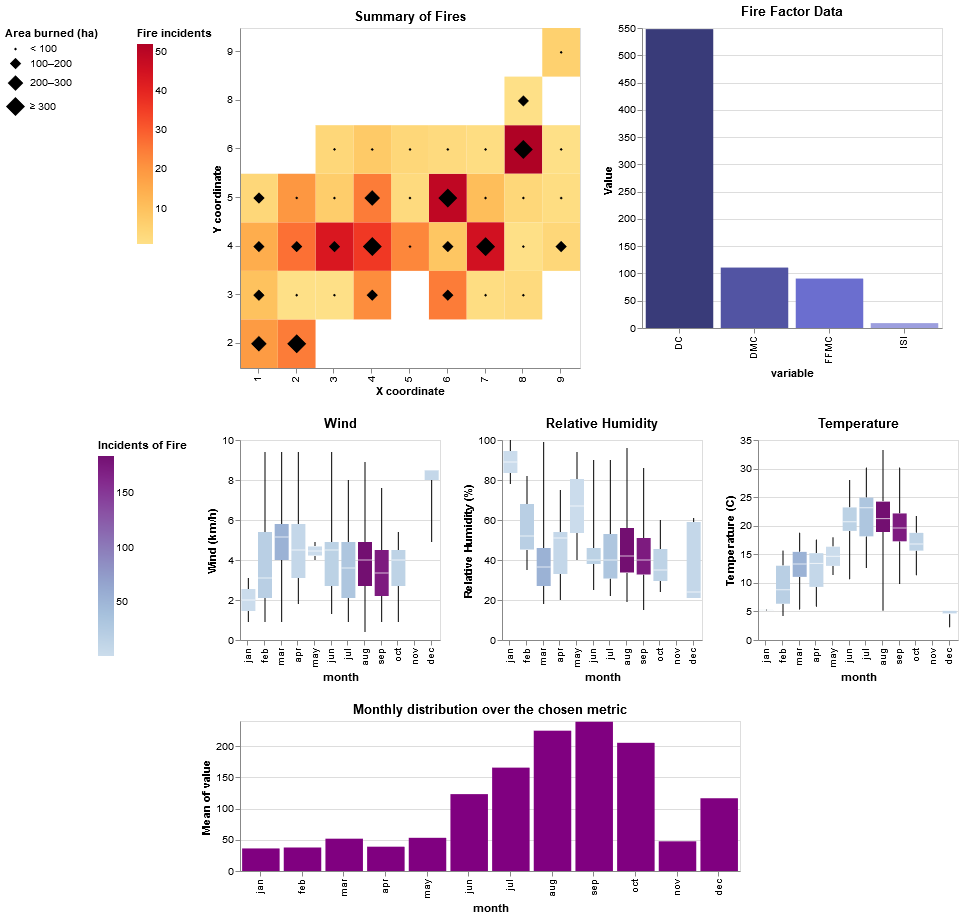

In [13]:
final_chart & monthly_dist